In [146]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# READING DATA FROM EXCEL SHEET

In [147]:
data = pd.read_excel('NetView_Viewership_Data.xlsx', sheet_name="viewership_data_Nov_Dec_2024",
                    engine='openpyxl', usecols="A:G", nrows=1585)

In [148]:
data.head()

,date,hour,day_of_week,viewers,show_finale,holiday,finale_name
0,2024-11-01,0,5,177140.0,0,0,NaN
1,2024-11-01,1,5,148073.0,0,0,NaN
2,2024-11-01,2,5,115361.0,0,0,NaN
3,2024-11-01,3,5,102277.0,0,0,NaN
4,2024-11-01,4,5,103369.0,0,0,NaN


In [149]:
data.describe()

,hour,day_of_week,viewers,show_finale,holiday
count,1584.000000,1584.000000,1.464000e+03,1584.000000,1584.000000
mean,11.500000,4.090909,3.117599e+05,0.002525,0.075758
std,6.924373,2.006135,1.584728e+05,0.050204,0.264693
min,0.000000,1.000000,8.554700e+04,0.000000,0.000000
25%,5.750000,2.000000,1.941150e+05,0.000000,0.000000
50%,11.500000,4.000000,2.913515e+05,0.000000,0.000000
75%,17.250000,6.000000,4.114620e+05,0.000000,0.000000
max,23.000000,7.000000,1.459274e+06,1.000000,1.000000


In [150]:
print(data[data['finale_name'].notna()])

           date  hour  day_of_week    viewers  show_finale  holiday  \
333  2024-11-14    21            4  1333514.0            1        0   
669  2024-11-28    21            4  1028174.0            1        0   
981  2024-12-11    21            3  1459274.0            1        0   
1557 2025-01-04    21            6        NaN            1        0   

          finale_name  
333        Baking Bad  
669     Game of Loans  
981   Stranger Danger  
1557    Leaky Finders  


In [151]:
viewers_data = data[data['viewers'].notna()].drop(columns=['finale_name']).copy()
viewers_data.describe()

,hour,day_of_week,viewers,show_finale,holiday
count,1464.000000,1464.000000,1.464000e+03,1464.000000,1464.000000
mean,11.500000,4.016393,3.117599e+05,0.002049,0.065574
std,6.924552,2.029113,1.584728e+05,0.045237,0.247620
min,0.000000,1.000000,8.554700e+04,0.000000,0.000000
25%,5.750000,2.000000,1.941150e+05,0.000000,0.000000
50%,11.500000,4.000000,2.913515e+05,0.000000,0.000000
75%,17.250000,6.000000,4.114620e+05,0.000000,0.000000
max,23.000000,7.000000,1.459274e+06,1.000000,1.000000


# SIMPLE EXPONENTIAL SMOOTHING - 

In [157]:
def train_test_split(data, split_size):
    train_size = int(len(data) * split_size)
    train_data = data['viewers'].values[:train_size]
    test_data = data['viewers'].values[train_size:]
    return train_data, test_data

def simple_exponential_smoothing(data, alpha):
    forecast = [data[0]]
    for n in range(1, len(data)):
        forecast.append(alpha * data[n-1] + (1 - alpha) * forecast[n-1])
    return forecast

def calculate_MAE(actual, forecast):
    return np.mean([abs(a - f) for a, f in zip(actual, forecast)])

def test_alphas(alphas, data):
    alpha_wise_MAEs = dict()
    min_error, best_alpha = None, -1
    for alpha in alphas:
        forecast = simple_exponential_smoothing(data, alpha)
        MAE = calculate_MAE(data, forecast)
        alpha_wise_MAEs[alpha] = MAE
        if min_error == None or MAE < min_error:
            min_error = MAE
            best_alpha = alpha
    return alpha_wise_MAEs, best_alpha

def plot_alpha_wise_MAE(alpha_wise_MAEs):
    alphas = list(alpha_wise_MAEs.keys())
    MAEs = list(alpha_wise_MAEs.values())
    plt.figure(figsize=(8, 4))
    plt.plot(alphas, MAEs, 'b-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Alpha vs MAE Relationship')
    plt.grid(True, linestyle='--', alpha=0.7)
    min_mae = min(MAEs)
    best_alpha = alphas[MAEs.index(min_mae)]
    plt.plot(best_alpha, min_mae, 'ro')
    plt.text(best_alpha, min_mae, f'\nBest α = {best_alpha}\nMAE = {min_mae:,.0f}', 
            verticalalignment='bottom')
    plt.tight_layout()
    plt.show()

def plot_actual_vs_forecast(actual, forecast, error, finales, title):
    plt.figure(figsize=(18, 6)) 
    ax = plt.gca() 
    ax.plot(actual, label='Actual Viewers', color='green', alpha=0.5) 
    ax.plot(forecast, label='Forecast', color='orange', linestyle='--') 
    for i in range(len(finales)): 
        if finales[i] == 1: 
            ax.axvline(x=i, color='blue', linestyle='--', alpha=0.3) 
    plt.ylabel('Number of Viewers') 
    plt.title(f'Viewers: Actual vs Forecast ({title})') 
    plt.grid(True, linestyle='--', alpha=0.7) 
    handles, labels = ax.get_legend_handles_labels() 
    handles.append(plt.Line2D([0], [0], color='blue', linestyle='-', alpha=0.7)) 
    labels.append('Finale') 
    plt.legend(handles, labels) 
    max_error = max(abs(error)) 
    mean_error = np.mean(abs(error)) 
    plt.text(0.8, 0.85, f'Max Abs Error: {max_error:.2f}\nMean Abs Error: {mean_error:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8)) 
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.savefig(f'plots/{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

Alpha Values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


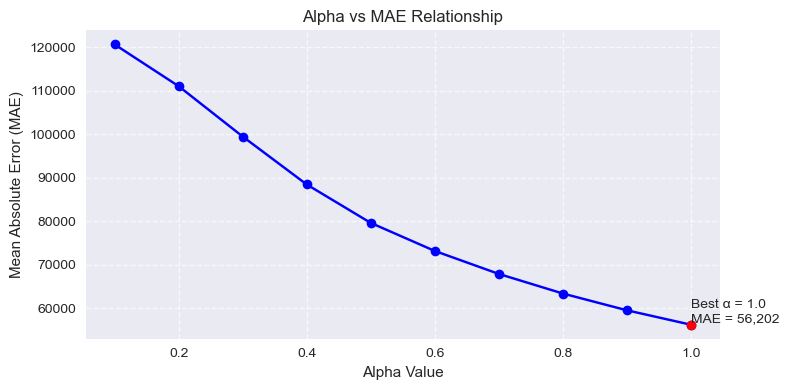

In [158]:
alpha_vals = np.arange(0.1, 1.1, 0.1)
print(f"Alpha Values: {alpha_vals}")
# Split data into training (75%) and testing (25%)
train_data, test_data = train_test_split(viewers_data, split_size=0.75)
alpha_wise_MAEs, best_alpha = test_alphas(alpha_vals, train_data)
plot_alpha_wise_MAE(alpha_wise_MAEs)

Mean Absolute Error for Simple Exponential Smoothing: 55530.79030054645


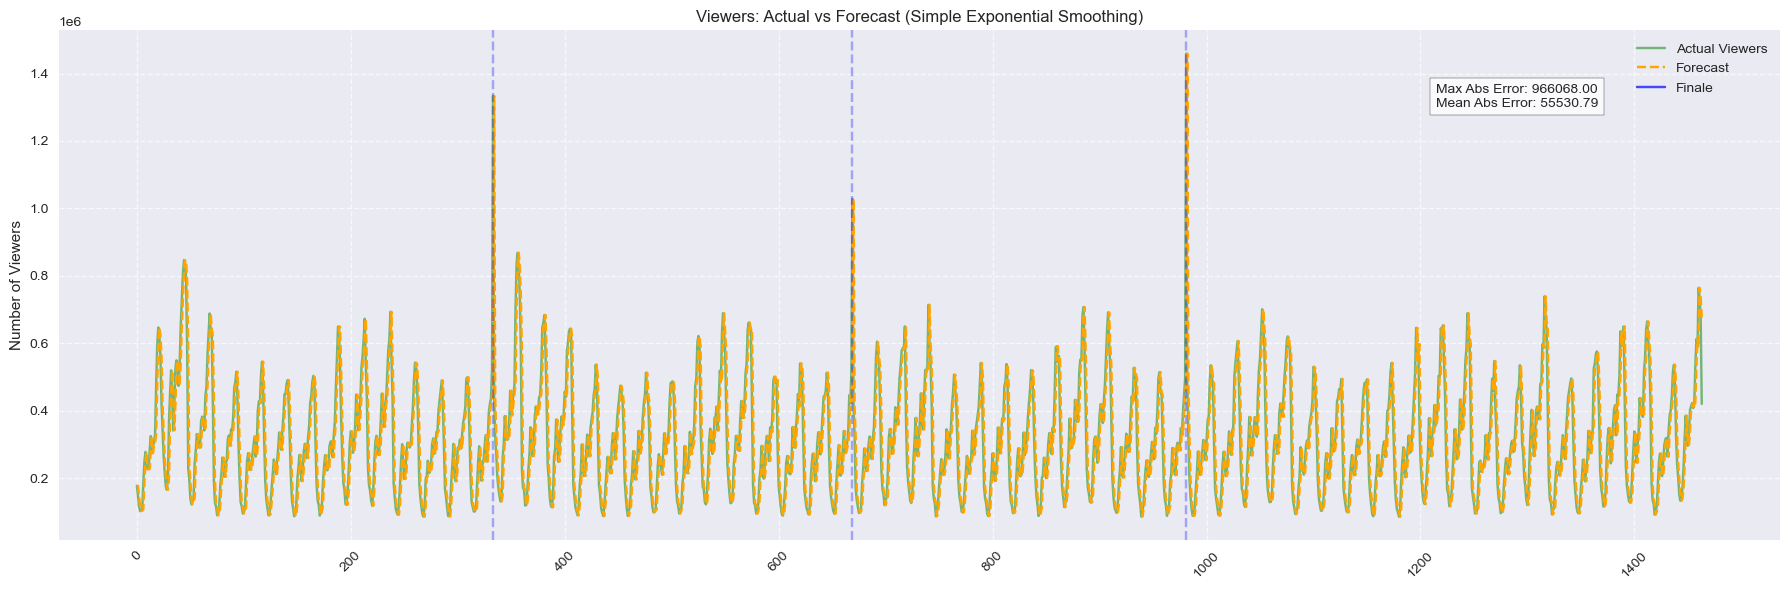

,date,hour,day_of_week,viewers,show_finale,holiday,sim_exp_smo_forecast,ses_error
0,2024-11-01,0,5,177140.0,0,0,177140.0,0.0
1,2024-11-01,1,5,148073.0,0,0,177140.0,-29067.0
2,2024-11-01,2,5,115361.0,0,0,148073.0,-32712.0
3,2024-11-01,3,5,102277.0,0,0,115361.0,-13084.0
4,2024-11-01,4,5,103369.0,0,0,102277.0,1092.0


In [159]:

viewers_data["sim_exp_smo_forecast"] = simple_exponential_smoothing(viewers_data['viewers'].values, best_alpha)
viewers_data["ses_error"] = viewers_data['viewers'] - viewers_data["sim_exp_smo_forecast"]
simple_exponential_smoothing_MAE = np.mean(abs(viewers_data['ses_error']))
print(f"Mean Absolute Error for Simple Exponential Smoothing: {simple_exponential_smoothing_MAE}")
plot_actual_vs_forecast(viewers_data['viewers'], viewers_data["sim_exp_smo_forecast"], viewers_data["ses_error"], viewers_data['show_finale'], 'Simple Exponential Smoothing')

# final_forecast = (best_alpha * viewers_data['viewers'].iloc[-1]) + (1 - best_alpha) * viewers_data["Simple Exponential Smoothing Forecast"].iloc[-1]
viewers_data.head()

# DOUBLE EXPONENTIAL SMOOTHING - 

In [160]:
def double_exponential_smoothing(actual, params):
    alpha, beta = params
    L = [actual.iloc[0]]
    T = [actual.iloc[1] - actual.iloc[0]]
    L_T = [L[0] + T[0]]
    forecast = [actual.iloc[0]]
    for t in range(1, len(actual)):
        L_t = (alpha * actual.iloc[t-1]) + ((1 - alpha) * (L[t-1] + T[t-1]))
        T_t = (beta * (L_t - L[t-1])) + ((1 - beta) * (T[t-1]))
        F_t = (L_t + T_t)
        L.append(L_t)
        T.append(T_t)
        forecast.append(F_t)
    return forecast

In [161]:
def plot_parameter_combinations(results_df):
    fig = plt.figure(figsize=(15, 5))
    alpha_values = sorted(results_df['alpha'].unique())
    beta_values = sorted(results_df['beta'].unique())
    X, Y = np.meshgrid(alpha_values, beta_values)
    Z = results_df.pivot(index='beta', columns='alpha', values='MAE').values
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis')
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Beta')
    ax1.set_zlabel('MAE')
    ax1.set_title('3D Surface Plot')
    fig.colorbar(surf)
    ax2 = fig.add_subplot(132)
    contour = ax2.contour(X, Y, Z, levels=15)
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.set_xlabel('Alpha')
    ax2.set_ylabel('Beta')
    ax2.set_title('Contour Plot')
    ax3 = fig.add_subplot(133)
    heatmap = ax3.pcolor(X, Y, Z, cmap='viridis')
    ax3.set_xlabel('Alpha')
    ax3.set_ylabel('Beta')
    ax3.set_title('Heatmap')
    fig.colorbar(heatmap)
    best_alpha = results_df.loc[results_df['MAE'].idxmin(), 'alpha']
    best_beta = results_df.loc[results_df['MAE'].idxmin(), 'beta']
    ax2.plot(best_alpha, best_beta, 'r*', markersize=15, label=f'Best (α={best_alpha:.2f}, β={best_beta:.2f})')
    ax2.legend()
    ax3.plot(best_alpha, best_beta, 'r*', markersize=15)
    plt.tight_layout()
    plt.show()

Best parameters:        Alpha: 1.00       Beta: 0.10
MAE: 56471.67


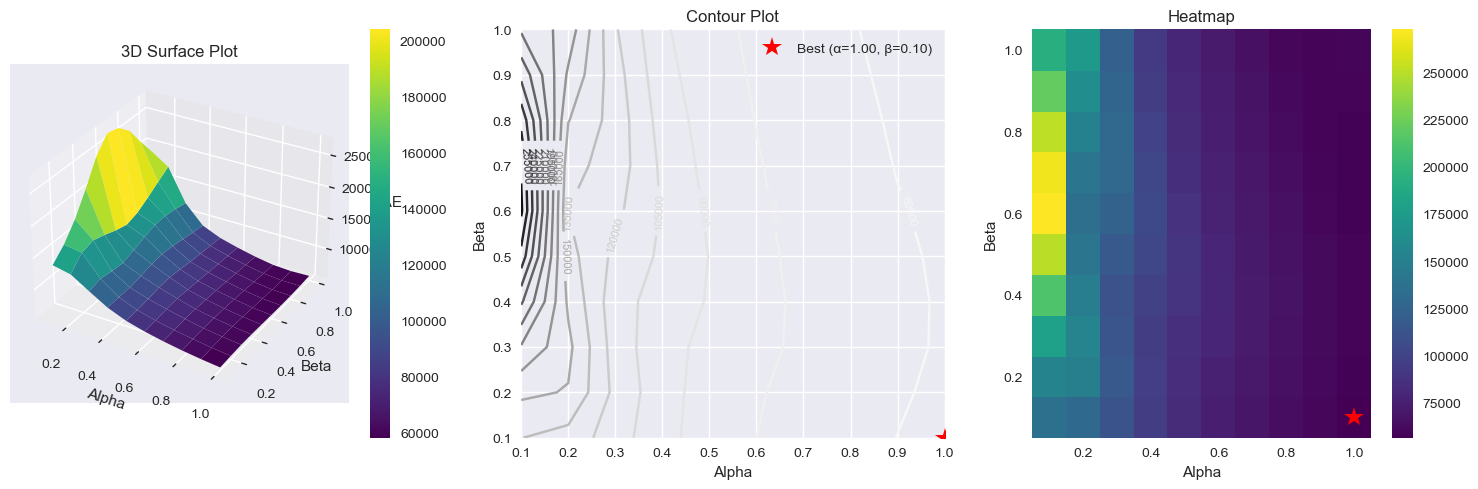

,date,hour,day_of_week,viewers,show_finale,holiday,sim_exp_smo_forecast,ses_error,dou_exp_smo_forecast,des_error
0,2024-11-01,0,5,177140.0,0,0,177140.0,0.0,177140.0000,0.0000
1,2024-11-01,1,5,148073.0,0,0,177140.0,-29067.0,150979.7000,-2906.7000
2,2024-11-01,2,5,115361.0,0,0,148073.0,-32712.0,121622.0300,-6261.0300
3,2024-11-01,3,5,102277.0,0,0,115361.0,-13084.0,88283.9270,13993.0730
4,2024-11-01,4,5,103369.0,0,0,102277.0,1092.0,76599.2343,26769.7657


In [162]:
alphas = np.arange(0.1, 1.1, 0.1)
betas = np.arange(0.1, 1.1, 0.1)
results = []
for alpha, beta in product(alphas, betas):
    params = (alpha, beta)
    forecast = double_exponential_smoothing(viewers_data['viewers'], params)
    mae = np.mean(abs(viewers_data['viewers'] - forecast))
    results.append({'alpha': alpha, 'beta': beta, 'MAE': mae})
results_data = pd.DataFrame(results)
best_params = results_data.loc[results_data['MAE'].idxmin()]
print(f"Best parameters:        Alpha: {best_params['alpha']:.2f}       Beta: {best_params['beta']:.2f}")
print(f"MAE: {best_params['MAE']:.2f}")
plot_parameter_combinations(results_data)

params = (best_params['alpha'], best_params['beta'])
viewers_data["dou_exp_smo_forecast"] = double_exponential_smoothing(viewers_data['viewers'], params)
viewers_data["des_error"] = viewers_data['viewers'] - viewers_data["dou_exp_smo_forecast"]
double_exponential_smoothing_MAE = np.mean(abs(viewers_data['des_error']))
viewers_data.head()

Mean Absolute Error for Double Exponential Smoothing: 56471.6668618948


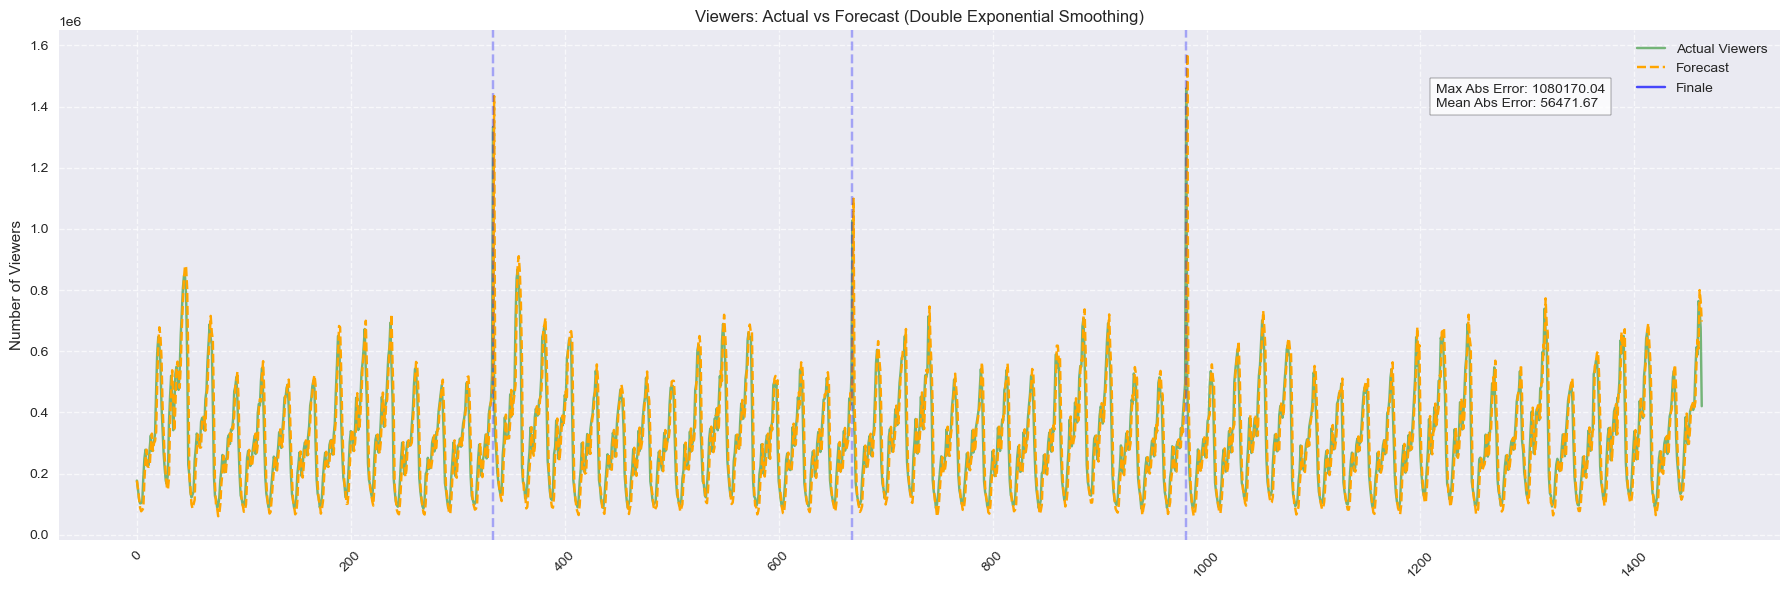

In [163]:
print(f"Mean Absolute Error for Double Exponential Smoothing: {double_exponential_smoothing_MAE}")
plot_actual_vs_forecast(viewers_data['viewers'], viewers_data["dou_exp_smo_forecast"], viewers_data["des_error"], viewers_data['show_finale'], 'Double Exponential Smoothing')

# TRIPLE EXPONENTIAL SMOOTHING - 

In [164]:
def triple_exponential_smoothing(actual, params):
    alpha, beta, gamma, seasonal_period = params
    L = [actual.iloc[0]]
    T = [(actual.iloc[1] - actual.iloc[0])]
    S = [actual.iloc[i] / (sum(actual.iloc[:seasonal_period]) / seasonal_period) for i in range(seasonal_period)]
    forecast = [actual.iloc[0]]
    for t in range(1, len(actual)):
        if t >= seasonal_period:
            L_t = alpha * (actual.iloc[t-1] / S[t - seasonal_period]) + (1 - alpha) * (L[t-1] + T[t-1])
            T_t = beta * (L_t - L[t-1]) + (1 - beta) * T[t-1]
            S_t = gamma * (actual.iloc[t] / L_t) + (1 - gamma) * S[t - seasonal_period]
        else:  
            L_t = alpha * actual.iloc[t-1] + (1 - alpha) * (L[t-1] + T[t-1])
            T_t = beta * (L_t - L[t-1]) + (1 - beta) * T[t-1]
            S_t = 1
        L.append(L_t)
        T.append(T_t)
        S.append(S_t)
        F_t = (L_t + T_t) * S_t
        forecast.append(F_t)
    return forecast

In [165]:
def plot_parameter_combinations(results_data):
    fig = plt.figure(figsize=(20, 5))
    for i, param in enumerate(['alpha', 'beta', 'gamma']): 
        ax = fig.add_subplot(141 + i)
        param_mae = results_data.groupby(param)['MAE'].mean()
        ax.plot(param_mae.index, param_mae.values, ['b-o','g-o','r-o'][i])
        ax.set(xlabel=param.capitalize(), ylabel='Average MAE', title=f'{param.capitalize()} vs Average MAE')
        if param == 'gamma':
            best_value = 0.4
            corresponding_mae = param_mae.loc[0.4]
            ax.plot(best_value, corresponding_mae, 'r*', markersize=15)
        else:
            ax.plot(param_mae.idxmin(), param_mae.min(), 'r*', markersize=15)
    scatter = fig.add_subplot(144, projection='3d').scatter(results_data['alpha'], results_data['beta'], results_data['gamma'], c=results_data['MAE'], cmap='viridis')
    fig.axes[-1].set(xlabel='Alpha', ylabel='Beta', zlabel='Gamma', title='Parameter Space\n(color = MAE)')
    fig.colorbar(scatter)
    plt.tight_layout()
    plt.show()

Best parameters:     Alpha: 0.10       Beta: 0.10     Gamma: 1.00
MAE: 23052.63


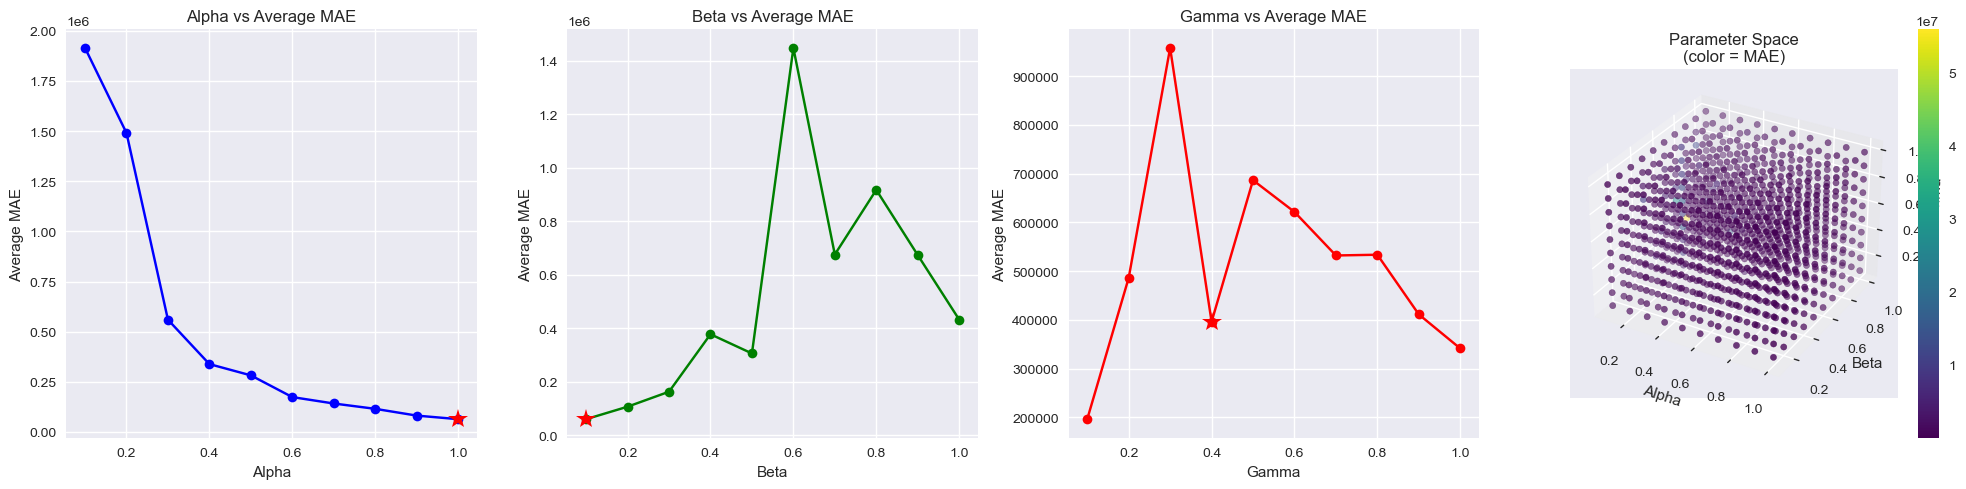

,date,hour,day_of_week,viewers,show_finale,holiday,sim_exp_smo_forecast,ses_error,dou_exp_smo_forecast,des_error,tri_exp_smo_forecast,tes_error
0,2024-11-01,0,5,177140.0,0,0,177140.0,0.0,177140.0000,0.0000,177140.000000,0.000000
1,2024-11-01,1,5,148073.0,0,0,177140.0,-29067.0,150979.7000,-2906.7000,122203.370000,25869.630000
2,2024-11-01,2,5,115361.0,0,0,148073.0,-32712.0,121622.0300,-6261.0300,96272.699300,19088.300700
3,2024-11-01,3,5,102277.0,0,0,115361.0,-13084.0,88283.9270,13993.0730,69854.778677,32422.221323
4,2024-11-01,4,5,103369.0,0,0,102277.0,1092.0,76599.2343,26769.7657,45094.472330,58274.527670


In [166]:
alphas = np.arange(0.1, 1.1, 0.1)
betas = np.arange(0.1, 1.1, 0.1)
gammas = np.arange(0.1, 1.1, 0.1)
seasonal_period = 168
results = []
for alpha, beta, gamma in product(alphas, betas, gammas):
    params = (alpha, beta, gamma, seasonal_period)
    forecast = triple_exponential_smoothing(viewers_data['viewers'], params)
    mae = np.mean(abs(viewers_data['viewers'] - forecast))
    results.append({'alpha': alpha, 'beta': beta, 'gamma': gamma, 'MAE': mae})
    
results_data = pd.DataFrame(results)
best_params = results_data.loc[results_data['MAE'].idxmin()]
print(f"Best parameters:     Alpha: {best_params['alpha']:.2f}       Beta: {best_params['beta']:.2f}     Gamma: {best_params['gamma']:.2f}")
print(f"MAE: {best_params['MAE']:.2f}")

plot_parameter_combinations(results_data)

params = (best_params['alpha'], best_params['beta'], best_params['gamma'], seasonal_period)
viewers_data["tri_exp_smo_forecast"] = triple_exponential_smoothing(viewers_data['viewers'], params)
viewers_data["tes_error"] = viewers_data['viewers'] - viewers_data["tri_exp_smo_forecast"]
triple_exponential_smoothing_MAE = np.mean(abs(viewers_data['tes_error']))
viewers_data.head()

Mean Absolute Error for Triple Exponential Smoothing: 23052.628386223863


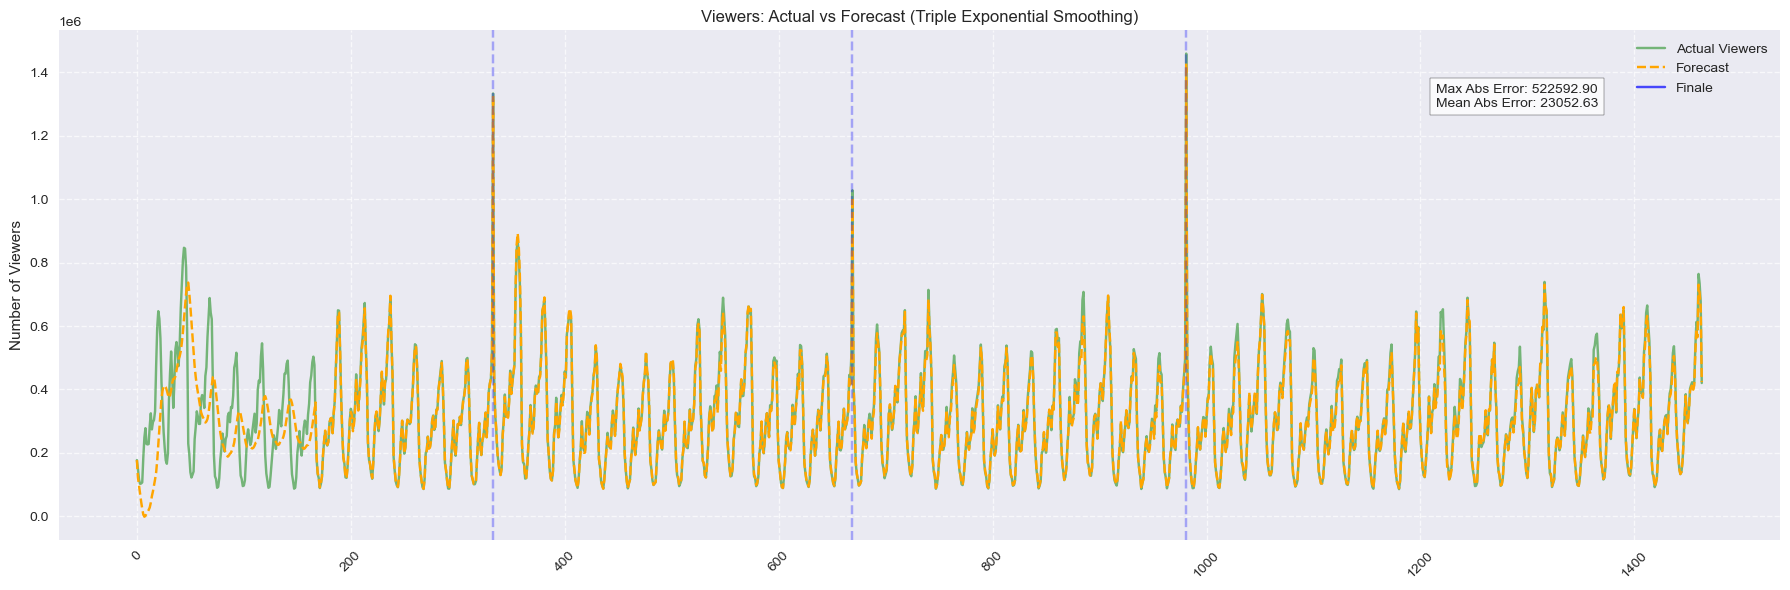

In [167]:
print(f"Mean Absolute Error for Triple Exponential Smoothing: {triple_exponential_smoothing_MAE}")
plot_actual_vs_forecast(viewers_data['viewers'], viewers_data["tri_exp_smo_forecast"], viewers_data["tes_error"], viewers_data['show_finale'], 'Triple Exponential Smoothing')

In [168]:
viewers_data.head()

,date,hour,day_of_week,viewers,show_finale,holiday,sim_exp_smo_forecast,ses_error,dou_exp_smo_forecast,des_error,tri_exp_smo_forecast,tes_error
0,2024-11-01,0,5,177140.0,0,0,177140.0,0.0,177140.0000,0.0000,177140.000000,0.000000
1,2024-11-01,1,5,148073.0,0,0,177140.0,-29067.0,150979.7000,-2906.7000,122203.370000,25869.630000
2,2024-11-01,2,5,115361.0,0,0,148073.0,-32712.0,121622.0300,-6261.0300,96272.699300,19088.300700
3,2024-11-01,3,5,102277.0,0,0,115361.0,-13084.0,88283.9270,13993.0730,69854.778677,32422.221323
4,2024-11-01,4,5,103369.0,0,0,102277.0,1092.0,76599.2343,26769.7657,45094.472330,58274.527670


# EXPLORATORY DATA ANALYSIS - 

In [169]:
result = viewers_data.groupby('day_of_week')['viewers'].sum().reset_index()
day_counts = viewers_data['day_of_week'].value_counts().reset_index()
day_counts.columns = ['day_of_week', 'Number of Days']
res = result.merge(day_counts, on='day_of_week').sort_values('day_of_week')
# 24 rows for 24 hours. Thus divide by 24
res['Number of Days'] = res['Number of Days'] / 24
res['viewers'] = (res['viewers'].astype(float) / res['Number of Days']).apply(lambda x: f'{x:.2f}')
print(res)

   day_of_week     viewers  Number of Days
0            1  6617471.00             9.0
1            2  6882916.89             9.0
2            3  7027930.62             8.0
3            4  6743724.12             8.0
4            5  7435946.11             9.0
5            6  8940560.56             9.0
6            7  8594574.00             9.0


/var/folders/b2/m5dk1c4s7wv9lrb81y7zxdy80000gn/T/ipykernel_78557/1110325845.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


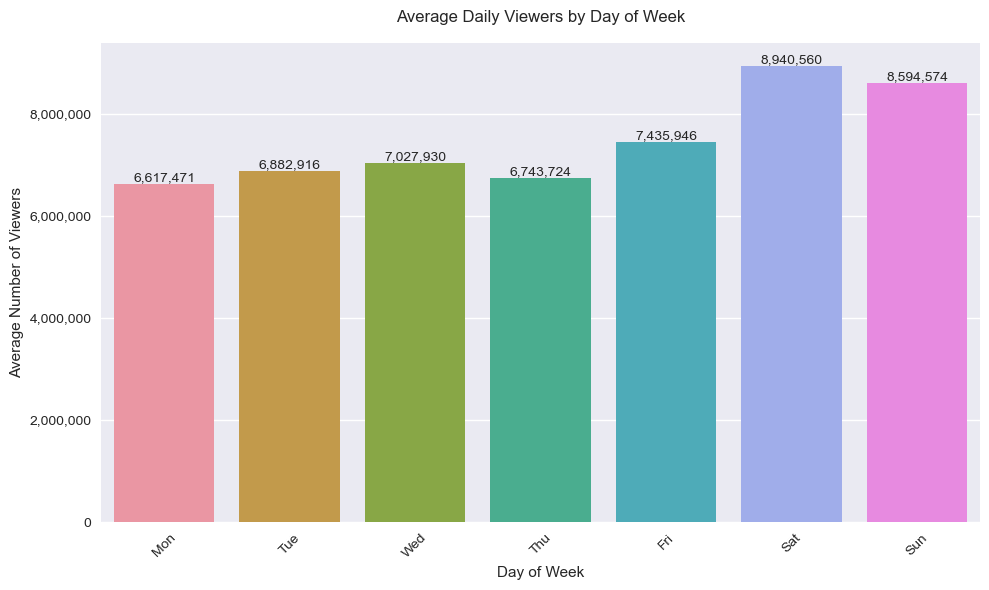

In [170]:
res['viewers'] = res['viewers'].astype(float)
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))
day_mapping = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
res['day_name'] = res['day_of_week'].map(day_mapping)
ax = sns.barplot(data=res, x='day_name', y='viewers')
plt.title('Average Daily Viewers by Day of Week', pad=15)
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Viewers')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
for i, v in enumerate(res['viewers']):
   ax.text(i, v, format(int(v), ','), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('plots/viewers_by_day.png', dpi=300, bbox_inches='tight')
plt.show()

In [171]:
res = viewers_data.groupby('hour')['viewers'].mean().reset_index()
print(res)

    hour        viewers
0      0  206832.311475
1      1  156215.262295
2      2  131234.459016
3      3  106288.868852
4      4  106719.098361
5      5  131505.065574
6      6  203406.786885
7      7  255739.114754
8      8  305269.229508
9      9  255328.655738
10    10  230667.475410
11    11  255150.196721
12    12  309540.721311
13    13  358252.606557
14    14  330315.639344
15    15  308026.475410
16    16  361207.852459
17    17  407329.065574
18    18  471122.163934
19    19  524078.295082
20    20  576007.540984
21    21  608685.901639
22    22  520414.344262
23    23  362899.836066


/var/folders/b2/m5dk1c4s7wv9lrb81y7zxdy80000gn/T/ipykernel_78557/3711410297.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


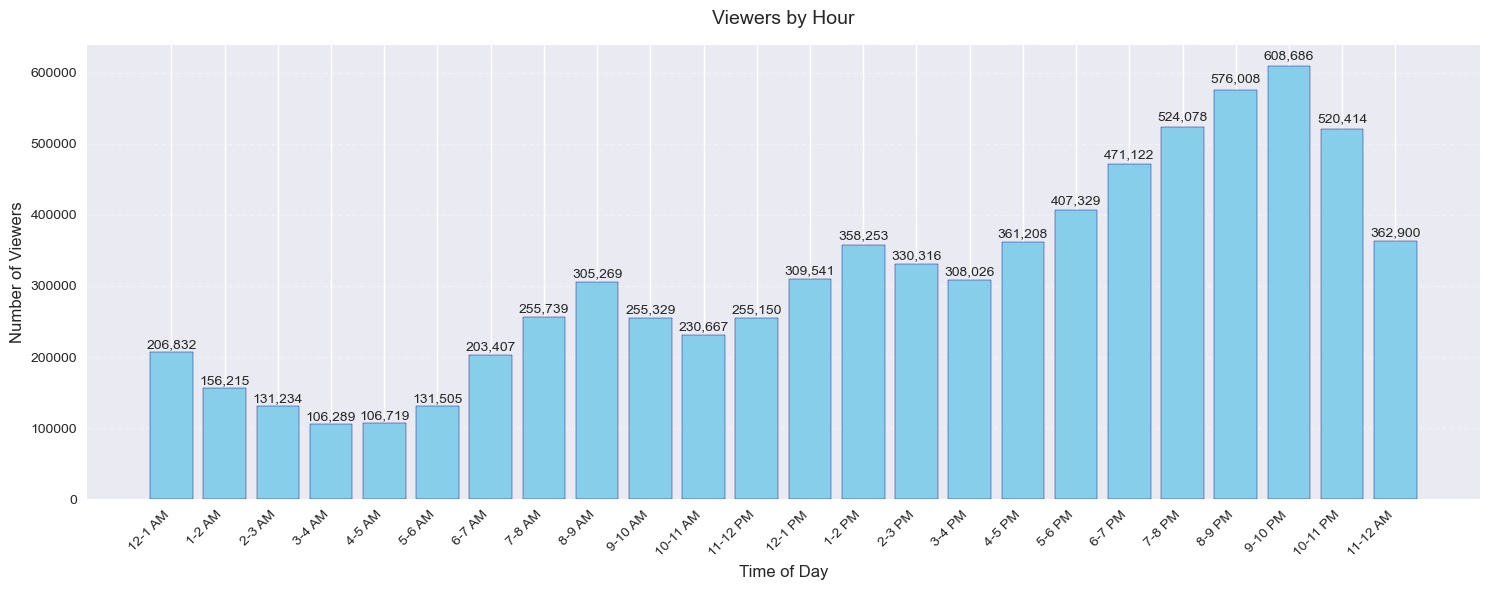

In [172]:
res['viewers'] = res['viewers'].astype(float)
res['hour'] = res['hour'].astype(int)

hour_labels = ['12-1 AM', '1-2 AM', '2-3 AM', '3-4 AM', '4-5 AM', '5-6 AM', '6-7 AM', '7-8 AM', '8-9 AM', '9-10 AM', '10-11 AM', '11-12 PM', '12-1 PM', '1-2 PM', '2-3 PM', '3-4 PM', '4-5 PM', '5-6 PM', '6-7 PM', '7-8 PM', '8-9 PM', '9-10 PM', '10-11 PM', '11-12 AM']
plt.style.use('seaborn')
plt.figure(figsize=(15, 6))
plt.bar(hour_labels, res['viewers'], color='skyblue', edgecolor='navy')
for i, v in enumerate(res['viewers']):
   plt.text(i, v * 1.01, f'{v:,.0f}', ha='center', va='bottom')
plt.title('Viewers by Hour', fontsize=14, pad=15)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Viewers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('plots/viewers_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

In [173]:
holiday_counts = viewers_data['holiday'].value_counts()
print(f"Number of non-holiday days (0): {holiday_counts[0]}")
print(f"Number of holiday days (1): {holiday_counts[1]}\n")
out = viewers_data.groupby('holiday')['viewers'].mean().reset_index()
print(out)

Number of non-holiday days (0): 1368
Number of holiday days (1): 96

   holiday        viewers
0        0  304174.430556
1        1  419852.437500


/var/folders/b2/m5dk1c4s7wv9lrb81y7zxdy80000gn/T/ipykernel_78557/437841306.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


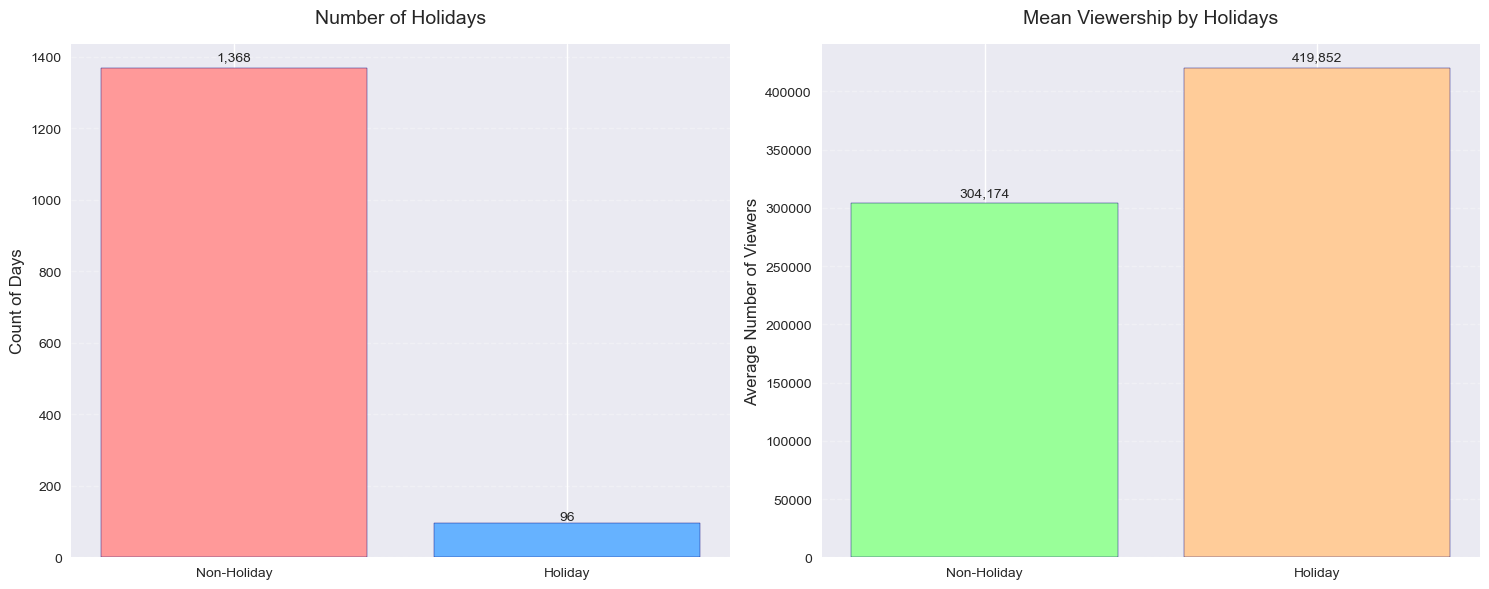

In [174]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
counts_data = viewers_data['holiday'].value_counts().reset_index()
counts_data = counts_data.sort_values('index')
counts_data.columns = ['holiday', 'count']
colors1 = ['#FF9999', '#66B2FF']
ax1.bar(['Non-Holiday', 'Holiday'], counts_data['count'], color=colors1, edgecolor='navy')
for i, v in enumerate(counts_data['count']):
   ax1.text(i, v + v*0.01, f'{v:,.0f}', ha='center', va='bottom')
ax1.set_title('Number of Holidays', fontsize=14, pad=15)
ax1.set_ylabel('Count of Days', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3, axis='y')
mean_data = viewers_data.groupby('holiday')['viewers'].mean().reset_index()
colors2 = ['#99FF99', '#FFCC99']
ax2.bar(['Non-Holiday', 'Holiday'], mean_data['viewers'], color=colors2, edgecolor='navy')
for i, v in enumerate(mean_data['viewers']):
   ax2.text(i, v + v*0.01, f'{v:,.0f}', ha='center', va='bottom')
ax2.set_title('Mean Viewership by Holidays', fontsize=14, pad=15)
ax2.set_ylabel('Average Number of Viewers', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('plots/holidays.png', dpi=300, bbox_inches='tight')
plt.show()

In [175]:
finale_counts = viewers_data['show_finale'].value_counts()
print(f"Number of non-holiday days (0): {finale_counts[0]}")
print(f"Number of holiday days (1): {finale_counts[1]}\n")
out2 = viewers_data.groupby('show_finale')['viewers'].mean().reset_index()
print(out2)

Number of non-holiday days (0): 1461
Number of holiday days (1): 3

   show_finale       viewers
0            0  3.097847e+05
1            1  1.273654e+06


/var/folders/b2/m5dk1c4s7wv9lrb81y7zxdy80000gn/T/ipykernel_78557/4280958374.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


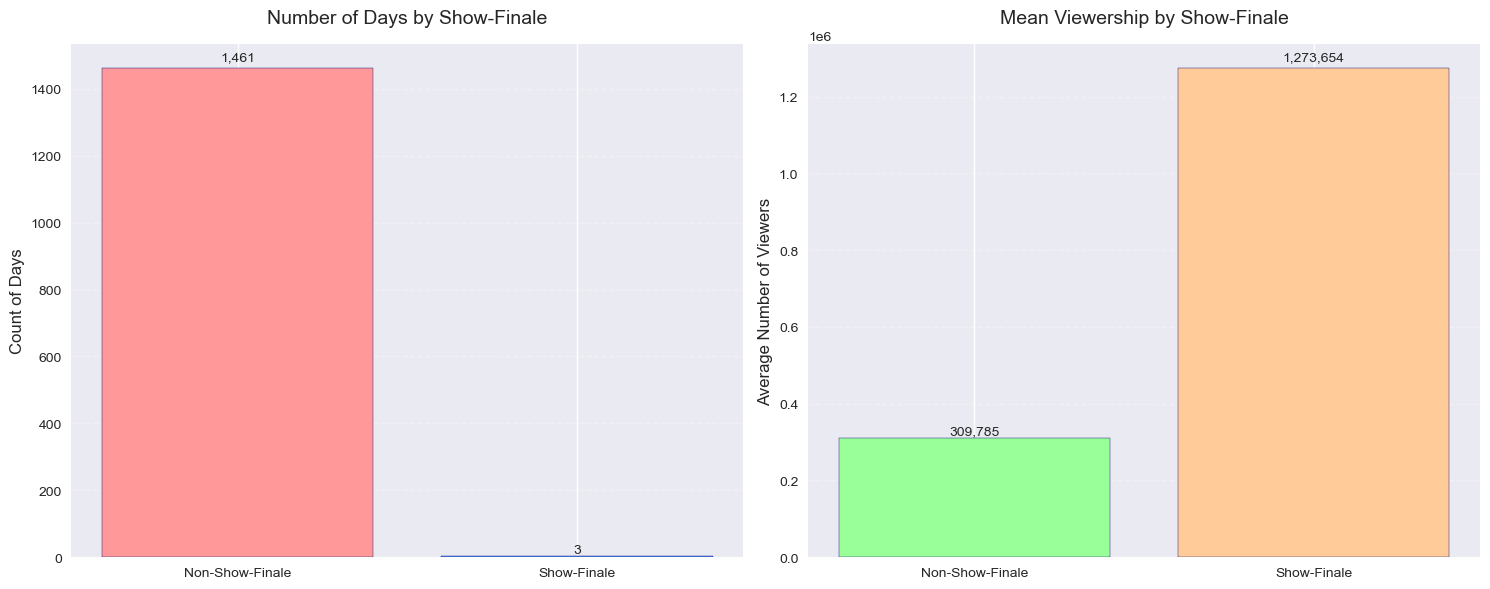

In [176]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
counts_data = viewers_data['show_finale'].value_counts().reset_index()
counts_data = counts_data.sort_values('index')
counts_data.columns = ['show_finale', 'count']
colors1 = ['#FF9999', '#66B2FF']
ax1.bar(['Non-Show-Finale', 'Show-Finale'], counts_data['count'], color=colors1, edgecolor='navy')
for i, v in enumerate(counts_data['count']):
   ax1.text(i, v + v*0.01, f'{v:,.0f}', ha='center', va='bottom')
ax1.set_title('Number of Days by Show-Finale', fontsize=14, pad=15)
ax1.set_ylabel('Count of Days', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3, axis='y')
mean_data = viewers_data.groupby('show_finale')['viewers'].mean().reset_index()
colors2 = ['#99FF99', '#FFCC99']
ax2.bar(['Non-Show-Finale', 'Show-Finale'], mean_data['viewers'], color=colors2, edgecolor='navy')
for i, v in enumerate(mean_data['viewers']):
   ax2.text(i, v + v*0.01, f'{v:,.0f}', ha='center', va='bottom')
ax2.set_title('Mean Viewership by Show-Finale', fontsize=14, pad=15)
ax2.set_ylabel('Average Number of Viewers', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('plots/show_finale.png', dpi=300, bbox_inches='tight')
plt.show()

# SARIMA -

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
exogenous_variables = ["show_finale", "holiday"]